In [ ]:
try:
    from imports import *
except ModuleNotFoundError:
    import sys; sys.path.append("../../")
    from imports import *

# Generalization properties of neural network approximations to frustrated magnet ground states

In [34]:
prefix = Path("data/data")
os.makedirs("assets", exist_ok=True)

def load(s, skip=1):
    with open(s) as f:
        for _ in range(skip): f.readline()
        if skip >= 0: columns = list(map(lambda s: s.strip("<>"), f.readline().strip("# \n").split(" ")))
        else: columns = None
        return pd.read_csv(f, sep=" ", comment="#", names=columns)

errorbar_kwargs = dict(ecolor="black", elinewidth=0.25, capsize=1, markeredgewidth=0.25,
                       markeredgecolor='black', clip_on=False, linestyle="none")

### Figure 1

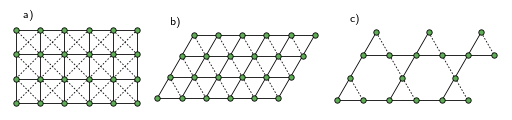

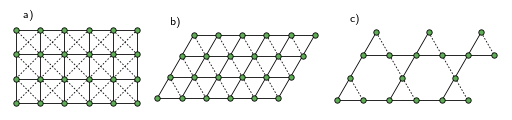

In [3]:
def _edges(grid, *fs):
    def _helper(grid, f):
        nx, ny = grid.shape; x1, y1 = grid.nonzero(); x2, y2 = f(x1, y1)
        p = (0 <= x2) & (x2 < nx) & (0 <= y2) & (y2 < ny) & grid[x2 % nx, y2 % ny]
        return np.column_stack([x1[p], y1[p], x2[p], y2[p]]).reshape(-1, 2, 2)
    return np.vstack([_helper(grid, f) for f in fs])

def _plot_graph(ax, cs, edges1, edges2, edgecolor="black"):
    ax.add_collection(LineCollection(edges1, linewidth=0.6, color=edgecolor, zorder=-1))
    ax.add_collection(LineCollection(edges2, linewidth=0.6, color=edgecolor, dashes=(0, [2, 2]), zorder=-1))
    ax.scatter(*cs, s=15, marker="o", facecolor="C0", edgecolor="black", linewidth=0.6)

matplotlib.pyplot.close("all")
with plt.style.context(["science", "scatter", style]):
    w, h = style["figure.figsize"]
    w1, w2 = 1, 1 + (3 / 5) * (1 / 2)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(w, w / 3), width_ratios=[w1, w2, w2])
    for ax in [ax1, ax2, ax3]: ax.axis("off"); ax.set_aspect("equal"); ax.margins(0.05, 0.1)
    fig.subplots_adjust(left=0, right=1, wspace=0.04)

    fs1 = (lambda x, y: (x + 1, y), lambda x, y: (x, y + 1))
    grid = np.ones((6, 4), dtype=bool)
    _plot_graph(ax1, grid.nonzero(), _edges(grid, *fs1),
                _edges(grid, lambda x, y: (x + 1, y + 1), lambda x, y: (x + 1, y - 1)))
    grid = np.ones((6, 4), dtype=bool)
    t = np.array([[1, 0.5], [0, np.sqrt(3) / 2]])
    _plot_graph(ax2, t @ np.vstack(grid.nonzero()), _edges(grid, *fs1) @ t.T,
                _edges(grid, lambda x, y: (x + 1, y - 1)) @ t.T)
    grid = np.ones((6, 4), dtype=bool); grid[1::2, 1::2] = False
    t = np.array([[1, 0.5], [0, np.sqrt(3) / 2]])
    _plot_graph(ax3, t @ np.vstack(grid.nonzero()), _edges(grid, *fs1) @ t.T,
                _edges(grid, lambda x, y: (x + 1, y - 1)) @ t.T)
    ax1.text(0.3, 3.5, "a)"); ax2.text(0.5, 3, "b)"); ax3.text(0.5, 3, "c)");
    fig.savefig("assets/Figure_1.pgf", backend="pgf")
fig

### Figure 2

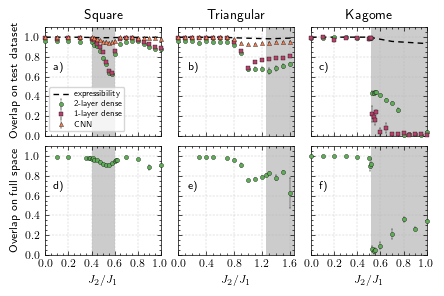

In [35]:
matplotlib.pyplot.close("all")
with plt.style.context(["science", "scatter", style]):
    w, h = style["figure.figsize"]
    fig, ax = plt.subplots(2, 3, figsize=(w, 0.8 * h))
    fig.subplots_adjust(wspace=0.15, hspace=0.1)

    for c in itertools.chain(*map(lambda x: x.spines.values(), itertools.chain(*ax))): c.set_zorder(1)
    for c in ax[0]: c.tick_params(labelbottom=False)
    for c in itertools.chain(ax[0][1:], ax[1][1:]): c.tick_params(labelleft=False)
    for i in range(2):
        ax[i][0].set_xlim((0, 1)); ax[i][1].set_xlim((0, 1.65)); ax[i][2].set_xlim((0, 1));
        for j in [0, 2]: ax[i][j].set_xticks(np.linspace(0, 1, 6))
        ax[i][1].set_xticks(np.linspace(0, 1.6, 5))
        for c in ax[i]: c.set_ylim((0, 1.1)); c.set_yticks(np.linspace(0, 1, 6)); c.grid(); c.set_axisbelow(True)
        for j, (cs, w) in enumerate([((0.4, 0), 0.2), ((1.25, 0), 1), ((0.52, 0), 1)]):
            ax[i][j].add_artist(matplotlib.patches.Rectangle(
                cs, w, 2, zorder=-1, alpha=0.2, color="black", linestyle="none"))
    for c in ax[1]: c.set_xlabel("$J_2/J_1$")
    for c, t in zip(ax[0], ["Square", "Triangular", "Kagome"]): c.set_title(t)
    ax[0][0].set_ylabel("Overlap on test dataset")
    ax[1][0].set_ylabel("Overlap on full space")

    markers = ["o", "s", "^"]
    labels = ["2-layer dense", "1-layer dense", "CNN"]
    
    def _one(ax, t, m, l):
        ax.errorbar(t.j2, (2 * t.rest_accuracy - 1).abs(), yerr=2 * t.rest_accuracy_err / np.sqrt(t.number),
                    marker=m, label=l, **errorbar_kwargs)
    
    ss = ["dense_64_ReLU_2_phase", "dense_64_ReLU_64_ReLU_2_phase", "conv/phase"]
    for s, m, l, skip in zip(ss, markers, labels, [1, 1, 0]):
        t = load(prefix / "NQS_Data/square/j2_dependence" / s / "data_new.dat", skip).assign(number=4)    
        _one(ax[0][0], t, m, l)
    ss = ["dense_64_ReLU_2", "dense_64_ReLU_64_ReLU_2", "j2_dependence/conv"]
    for s, m, l, skip in zip(ss, markers, labels, [1, 0, 1]):
        t = load(prefix / "NQS_Data/triangle" / s / "data_new.dat", skip).assign(number=4)
        t = t.sort_values(by="j2")[t.j2 <= 1.65]
        _one(ax[0][1], t, m, l)
    ss = ["dense_64_ReLU_2", "dense_64_ReLU_64_ReLU_2"]
    for s, m, l, skip in zip(ss, markers, labels, [1, 1]):
        t = load(prefix / "NQS_Data/kagome/j2_dependence/quadratic/phase" / s / "data_new.dat", skip) \
                .assign(number=4)
        _one(ax[0][2], t, m, l)
    ss = ["square/j2_dependence/dense_64_ReLU_64_ReLU_2_phase",
          "triangle/dense_64_ReLU_64_ReLU_2",
          "kagome/j2_dependence/quadratic/phase/dense_64_ReLU_64_ReLU_2"]
    for c, s in zip(ax[0], ss):
        t = pd.read_csv(prefix / "NQS_Data" / s / "expressibility.dat", sep=r"\s+", names=["j2", "overlap"])
        c.plot(t.j2, t.overlap, dashes=(4, 3), color="black", marker="none", label="expressibility")
    ss = ["square24", "triangle24", "kagome24"]
    for c, s in zip(ax[1], ss):
        t = pd.read_csv(prefix / "SR" / s / "eps_1e-3_solve/results_average.dat", sep=r"\s+",
                        names=["j2", "energy", "energy_err", "overlap", "overlap_err"])
        c.errorbar(t.j2, t.overlap, yerr=t.overlap_err, **errorbar_kwargs, marker="o")

    ax[0][0].legend(fontsize=6, labelspacing=0.3, handletextpad=0.5)
    ax[0][0].text(0.07, 0.67, "a)"); ax[0][1].text(0.14, 0.67, "b)"); ax[0][2].text(0.07, 0.67, "c)")
    ax[1][0].text(0.07, 0.67, "d)"); ax[1][1].text(0.14, 0.67, "e)"); ax[1][2].text(0.07, 0.67, "f)")
    
    fig.savefig("assets/Figure_2.pgf", backend="pgf")
fig

### Figures 3 & 4

In [31]:
t1 = load(prefix / Path("NQS_Data/kagome/f_dependence/quadratic/phase/data_new.dat")).assign(number=10) \
        .assign(test_overlap=lambda x: 2 * x.test_accuracy - 1) \
        .assign(test_overlap_err=lambda x: 2 * x.test_accuracy_err / np.sqrt(x.number))
t2a = load(prefix / "NQS_Data/kagome/j2_dependence/quadratic/amplitude/dense_64_ReLU_64_ReLU_1/data.dat").assign(number=4)
t2s = load(prefix / "NQS_Data/kagome/j2_dependence/quadratic/phase/dense_64_ReLU_64_ReLU_2/data_new.dat").assign(number=4)

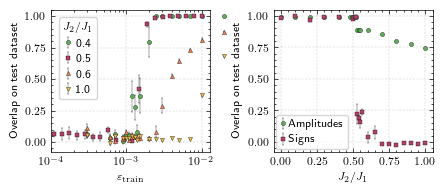

In [46]:
with plt.style.context(["science", "scatter", style]):
    w, h = style["figure.figsize"]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(w, h / 2))
    fig.subplots_adjust(wspace=0.4)
    for j2, m in zip(np.sort(t1["j2"].unique()), ['o', 's', '^', 'v']):
        chunk = t1[np.isclose(t1["j2"], j2) & (t1["train_ratio"] > 1e-4)]
        ax1.errorbar(chunk["train_ratio"], chunk["test_overlap"], yerr=chunk["test_overlap_err"],
                     marker=m, label=j2, **errorbar_kwargs)
    ax1.set_xscale('log'); ax1.set_xlim((1e-4, 1.3e-2))
    ax1.set_xlabel(r"$\varepsilon_\mathrm{train}$"); ax1.set_ylabel("Overlap on test dataset")
    ax1.grid(); ax1.legend(title=r"$J_2/J_1$", frameon=True, borderaxespad=0.7, handlelength=0.5, handletextpad=0.5)

    ax2.errorbar(t2a["j2"], t2a["rest_overlap"], yerr=t2a["rest_overlap_err"] / np.sqrt(t2a["number"]),
                 marker="o", label=r"Amplitudes\hspace{-5pt}", **errorbar_kwargs)
    # The original scripts for the paper use 2 * rest_accuracy - 1 here instead of rest_overlap. The values are close,
    # but not quite the same 😢 I guess, rest_overlap was not correctly weighted and that's why we didn't use it for plotting.
    ax2.errorbar(t2s["j2"], 2 * t2s["rest_accuracy"] - 1, yerr=2 * t2s["rest_accuracy_err"] / np.sqrt(t2s["number"]), label="Signs",
                 marker="s", **errorbar_kwargs)
    ax2.set_xlabel(r"$J_2/J_1$"); ax2.set_xticks(np.arange(0, 1.1, 0.25)); ax2.set_ylabel("Overlap on test dataset")
    ax2.grid(); ax2.legend(frameon=True, loc="lower left", borderaxespad=0.2, handlelength=0.5, handletextpad=0.2)
    fig.savefig("assets/Figure_3.pgf", backend="pgf")
fig

### Figure 5

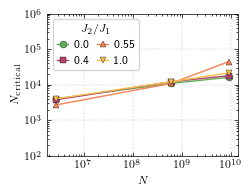

In [49]:
fix = lambda t: t.assign(rest_overlap=lambda x: 2 * x.rest_accuracy - 1)
t = pd.concat([
    fix(load(prefix / "NQS_Data/square/f_dependence/dense_64_ReLU_64_ReLU_2_phase/data_new.dat")).assign(spins=24),
    fix(load(prefix / "NQS_Data/square/f_dependence/32/data_new.dat", skip=0)).assign(spins=32),
    load(prefix / "NQS_Data/square/f_dependence/36/data_new.dat", skip=0).assign(spins=36)])
t = t[abs(t["rest_overlap"]) >= 1.5e-1].groupby(["j2", "spins"])["train_ratio"].min().reset_index() \
        .assign(hilbert=lambda x: scipy.special.binom(x.spins, x.spins // 2))

with plt.style.context(["science", "scatter", style]):
    w, h = style["figure.figsize"]
    fig, ax = plt.subplots(figsize=(w / 2, h / 2))
    for j2, m in zip(np.sort(t["j2"].unique()), ['o', 's', '^', 'v']):
        chunk = t[np.isclose(t["j2"], j2)]
        ax.plot(chunk["hilbert"], chunk["train_ratio"] * chunk["hilbert"], label=j2,
                ls='-', marker=m, markersize=5, markeredgewidth=0.25, markeredgecolor='black')
    ax.set_xscale('log'); ax.set_ylim((1e2, 1e6)); ax.set_yscale('log')
    ax.set_xlabel(r"$N$"); ax.set_ylabel(r"$N_\mathrm{critical}$"); ax.grid();
    ax.legend(title=r"$J_2/J_1$", loc="upper left", ncol=2, columnspacing=0.75,
              borderaxespad=0.5, handlelength=1, handletextpad=0.5)
    fig.savefig("assets/Figure_5.pgf", backend="pgf")
fig